In [1]:
!bash /home/azureuser/cloudfiles/code/blobfuse/blobfuse_raadsinformatie.sh

In [6]:
import sys
sys.path.append("..")

# Select where to run notebook: "azure" or "local"
my_run = "azure"

import my_secrets as sc
import settings as st

if my_run == "azure":
    import config_azure as cf
elif my_run == "local":
    import config as cf


import os
if my_run == "azure":
    if not os.path.exists(cf.HUGGING_CACHE):
        os.mkdir(cf.HUGGING_CACHE)
    os.environ["TRANSFORMERS_CACHE"] = cf.HUGGING_CACHE

import pandas as pd
# setup environment GEITje-7B Finetuning
# - pip install torch
# - pip install datasets
# - pip install transformers
# - pip install trl
# - pip install accelerate (restart after)
# - switch device_map='auto' to avaoid memory error

# - pip install sentencepiece
# - pip install jupyter
# - pip install protobuf 



### Notebook Overview
Goal: analyse the baselines, understand why they work so well

In [7]:
logreg = pd.read_pickle(f"{cf.output_path}/predictionsFinal/baselines/LogisticRegressionpredictions.pkl")
linsvc = pd.read_pickle(f"{cf.output_path}/predictionsFinal/baselines/LinearSVCpredictions.pkl")
nb = pd.read_pickle(f"{cf.output_path}/predictionsFinal/baselines/MultinomialNBpredictions.pkl")

overview = pd.read_pickle(f"{cf.output_path}/predictionsFinal/baselines/overview.pkl")

predictions = pd.concat([logreg, linsvc, nb])

In [15]:
from transformers import AutoTokenizer
from collections import Counter
from sklearn.metrics import classification_report
import sys
sys.path.append('../scripts/') 
import prompt_template as pt
import warnings
warnings.simplefilter('ignore')


import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def percentage_mistakes(count):
    return f"{round(count/1100*100,1)}%"

def mistakes(df, detailed=False):
    print('MISTAKES. INCLUDES PREDICTIONS ERRORS.')

    # select all response where the prediction was not correct
    mistakes = df.loc[df['label'] != df['prediction']]

    # groupby run_id so we get the amount of mistakes per run
    mistakes_per_run = mistakes.groupby('run_id').size().reset_index(name='count')
    mistakes_per_run['percentage of total predictions'] = mistakes_per_run['count'].apply(percentage_mistakes)
    print("Total amount of mistakes per run:")
    display(mistakes_per_run)

    # for each run get the amount of mistakes per class
    df_count_class = pd.DataFrame(columns=pt.get_class_list())
    for run_id in set(mistakes['run_id']):
        # select mistakes of current runid
        subdf = mistakes.loc[mistakes['run_id']==run_id]
        # count mistakes per class
        class_count = dict(Counter(subdf['label']))

        # if a class is not included in mistakes, set counter to 0
        for category in pt.get_class_list():
            if category not in class_count.keys():
                class_count[category] = 0

        # add count of class to df
        df_count_class.loc[len(df_count_class)] = class_count

    # reset index to runids
    df_count_class.index = list(set(mistakes['run_id']))
    print("Amount of mistakes per class for each run:")
    display(df_count_class)

    # For each run get for each class the highest mistakes
    df_highest_class = pd.DataFrame(columns=pt.get_class_list())
    for run_id in set(mistakes['run_id']):
        # select mistakes of current runid
        subdf = mistakes.loc[mistakes['run_id']==run_id]
        # count mistakes of runid
        count_mistakes_per_class = dict(Counter(subdf['label']))

        class_count = subdf.groupby('label')['prediction'].value_counts().reset_index(name='count')
        highest_per_class = dict()
        for label in set(class_count['label']):
            # for each class select the class for which it made the most mistakes
            highest_count_row = class_count.iloc[class_count[class_count['label'] == label]['count'].idxmax()]
            highest_per_class[label] = f"{highest_count_row['prediction']} ({highest_count_row['count']} out of {count_mistakes_per_class[label]})"

        # add to df
        df_highest_class.loc[len(df_highest_class)] = highest_per_class
    # reset index to run_id
    df_highest_class.index = list(set(mistakes['run_id']))
    print("Highest mistakes per class for each run:")
    display(df_highest_class.transpose())


def predictions_per_class(df):
    df_predictions_per_class = pd.DataFrame(columns=pt.get_class_list())
    for run_id in set(df['run_id']):
        subdf = df.loc[df['run_id']==run_id]
        count_predictions = dict(Counter(subdf['prediction']))
        df_predictions_per_class.loc[len(df_predictions_per_class)] = count_predictions

    df_predictions_per_class.index = list(set(df['run_id']))
    display(df_predictions_per_class.transpose())


def plot_confusion_matrix(df):
    run_ids = sorted(list(set(df['run_id'])))

    for run_id in run_ids:
        subdf = df.loc[df['run_id']==run_id]
        class_labels = list(set(subdf['prediction']) | set(subdf['label']))
        label_encoder = LabelEncoder()
        label_encoder.fit(class_labels)
        y_true_labels = subdf['label']
        y_true = label_encoder.transform(y_true_labels)
        y_pred_labels = subdf['prediction']
        y_pred = label_encoder.transform(y_pred_labels)

        class_names = label_encoder.classes_

        cm = confusion_matrix(y_true, y_pred)


        # Display the confusion matrix using seaborn heatmap
        print("RUN_ID:", run_id)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()



In [13]:
display(predictions.iloc[1:4])

,path,id,num_pages,MistralTokens,count_MistralTokens,LlamaTokens,count_LlamaTokens,old_label,md5_hash,balanced_split,trunc_txt,trunc_col,label,prediction,model,date,run_id
1,/home/azureuser/cloudfiles/code/blobfuse/raads...,10470,2.0,"[▁Geme, ente, ▁Amsterdam, <0x0A>, %, ▁Geme, en...",1179,"[▁Geme, ente, ▁Amsterdam, <0x0A>, %, ▁Geme, en...",1167,Actualiteit,a72c3857912f5e79874002c849d92da7,test,Gemeente Amsterdam\n% Gemeenteraad R\n% Raadsa...,TruncationLlamaTokensFront100Back100,Actualiteit,Actualiteit,LogisticRegression,2024-05-15 16:06:08.417730+02:00,LogisticRegression_fulltext
2,/home/azureuser/cloudfiles/code/blobfuse/raads...,10006,4.0,"[▁x, ▁Geme, ente, ▁Amsterdam, ▁Z, ▁S, <0x0A>, ...",1747,"[▁x, ▁Geme, ente, ▁Amsterdam, ▁Z, ▁S, <0x0A>, ...",1731,Actualiteit,255354d8d7f5d5a042d9dcf57a6a4ed4,test,x Gemeente Amsterdam Z S\n% Raadscommissie voo...,TruncationLlamaTokensFront100Back100,Actualiteit,Agenda,LogisticRegression,2024-05-15 16:06:08.417730+02:00,LogisticRegression_fulltext
3,/home/azureuser/cloudfiles/code/blobfuse/raads...,10339,1.0,"[▁x, ▁Geme, ente, ▁Amsterdam, ▁R, <0x0A>, G, e...",443,"[▁x, ▁Geme, ente, ▁Amsterdam, ▁R, <0x0A>, G, e...",428,Actualiteit,67c7ff0ccd3762f612070c4babb7c5b7,test,x Gemeente Amsterdam R\nGemeenteraad\n% Gemeen...,TruncationLlamaTokensFront100Back100,Actualiteit,Actualiteit,LogisticRegression,2024-05-15 16:06:08.417730+02:00,LogisticRegression_fulltext


RUN_ID: LinearSVC_first200_last0


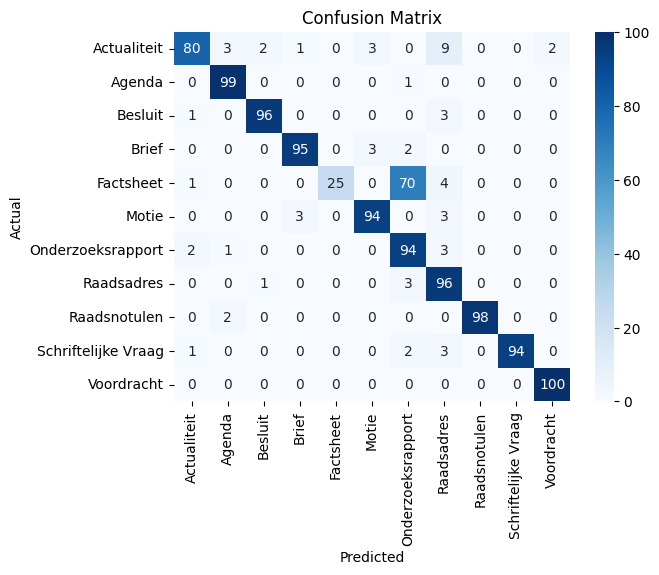

RUN_ID: LogisticRegression_first200_last0


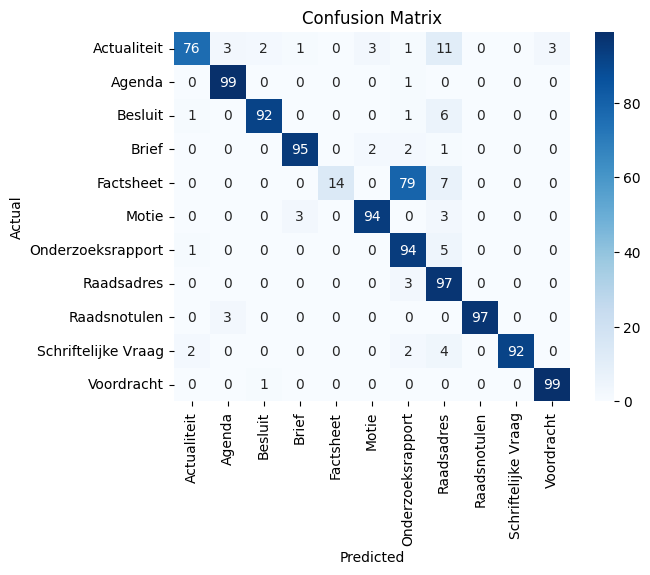

RUN_ID: MultinomialNB_first200_last0


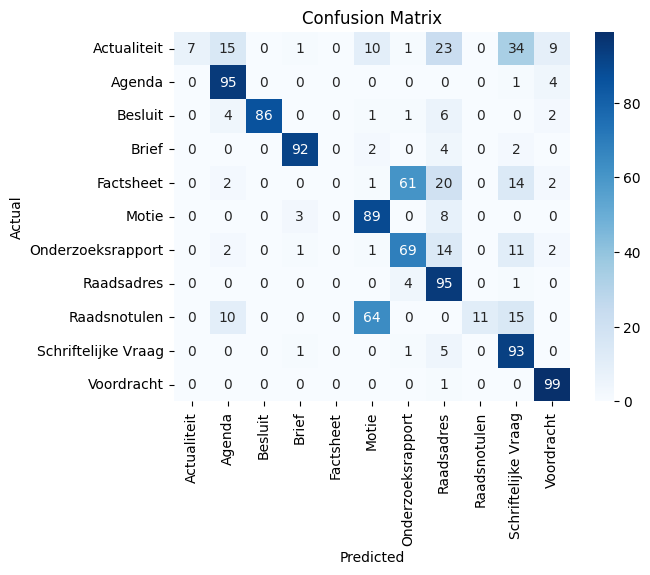

In [16]:
plot_confusion_matrix(predictions.loc[predictions['trunc_col']=='TruncationLlamaTokensFront200Back0'])

In [17]:
mistakes(predictions)
predictions_per_class(predictions)

MISTAKES. INCLUDES PREDICTIONS ERRORS.
Total amount of mistakes per run:


,run_id,count,percentage of total predictions
0,LinearSVC_first100_last0,128,11.6%
1,LinearSVC_first100_last100,122,11.1%
2,LinearSVC_first200_last0,129,11.7%
3,LinearSVC_fulltext,100,9.1%
4,LogisticRegression_first100_last0,160,14.5%
5,LogisticRegression_first100_last100,162,14.7%
6,LogisticRegression_first200_last0,151,13.7%
7,LogisticRegression_fulltext,138,12.5%
8,MultinomialNB_first100_last0,356,32.4%
9,MultinomialNB_first100_last100,368,33.5%


Amount of mistakes per class for each run:


,Voordracht,Besluit,Schriftelijke Vraag,Brief,Raadsadres,Onderzoeksrapport,Raadsnotulen,Agenda,Motie,Actualiteit,Factsheet
LinearSVC_fulltext,1,3,7,2,0,6,0,1,5,21,54
MultinomialNB_first100_last100,1,23,7,6,1,34,100,1,10,85,100
LinearSVC_first100_last100,1,4,7,7,1,5,2,1,5,20,69
LogisticRegression_fulltext,1,6,7,3,1,8,4,1,6,30,71
LogisticRegression_first100_last0,2,8,8,5,5,4,2,3,6,27,90
LinearSVC_first100_last0,1,4,6,4,6,5,2,1,6,21,72
LogisticRegression_first200_last0,1,8,8,5,3,6,3,1,6,24,86
LinearSVC_first200_last0,0,4,6,5,4,6,2,1,6,20,75
MultinomialNB_first100_last0,2,18,8,7,8,26,100,5,11,71,100
MultinomialNB_fulltext,1,73,4,89,8,13,100,1,11,100,100


Highest mistakes per class for each run:


,LinearSVC_fulltext,MultinomialNB_first100_last100,LinearSVC_first100_last100,LogisticRegression_fulltext,LogisticRegression_first100_last0,LinearSVC_first100_last0,LogisticRegression_first200_last0,LinearSVC_first200_last0,MultinomialNB_first100_last0,MultinomialNB_fulltext,MultinomialNB_first200_last0,LogisticRegression_first100_last100
Voordracht,Besluit (1 out of 1),Raadsadres (1 out of 1),Raadsadres (1 out of 1),Besluit (1 out of 1),Besluit (1 out of 2),Raadsadres (1 out of 1),Besluit (1 out of 1),NaN,Agenda (1 out of 2),Raadsadres (1 out of 1),Raadsadres (1 out of 1),Besluit (1 out of 2)
Besluit,Raadsadres (2 out of 3),Agenda (10 out of 23),Raadsadres (3 out of 4),Raadsadres (4 out of 6),Raadsadres (8 out of 8),Raadsadres (3 out of 4),Raadsadres (6 out of 8),Raadsadres (3 out of 4),Raadsadres (9 out of 18),Schriftelijke Vraag (35 out of 73),Raadsadres (6 out of 14),Raadsadres (5 out of 8)
Schriftelijke Vraag,Raadsadres (4 out of 7),Raadsadres (4 out of 7),Raadsadres (4 out of 7),Raadsadres (5 out of 7),Raadsadres (4 out of 8),Raadsadres (4 out of 6),Raadsadres (4 out of 8),Raadsadres (3 out of 6),Raadsadres (5 out of 8),Onderzoeksrapport (2 out of 4),Raadsadres (5 out of 7),Raadsadres (4 out of 9)
Brief,Onderzoeksrapport (2 out of 2),Raadsadres (3 out of 6),Motie (4 out of 7),Agenda (1 out of 3),Motie (2 out of 5),Motie (2 out of 4),Motie (2 out of 5),Motie (3 out of 5),Raadsadres (6 out of 7),Schriftelijke Vraag (54 out of 89),Raadsadres (4 out of 8),Onderzoeksrapport (3 out of 7)
Raadsadres,NaN,Onderzoeksrapport (1 out of 1),Besluit (1 out of 1),Schriftelijke Vraag (1 out of 1),Onderzoeksrapport (4 out of 5),Onderzoeksrapport (4 out of 6),Onderzoeksrapport (3 out of 3),Onderzoeksrapport (3 out of 4),Onderzoeksrapport (5 out of 8),Schriftelijke Vraag (6 out of 8),Onderzoeksrapport (4 out of 5),Onderzoeksrapport (2 out of 3)
Onderzoeksrapport,Agenda (2 out of 6),Schriftelijke Vraag (14 out of 34),Raadsadres (3 out of 5),Raadsadres (4 out of 8),Raadsadres (4 out of 4),Raadsadres (3 out of 5),Raadsadres (5 out of 6),Raadsadres (3 out of 6),Raadsadres (16 out of 26),Schriftelijke Vraag (11 out of 13),Raadsadres (14 out of 31),Raadsadres (3 out of 3)
Raadsnotulen,NaN,Motie (52 out of 100),Agenda (2 out of 2),Actualiteit (2 out of 4),Agenda (2 out of 2),Agenda (2 out of 2),Agenda (3 out of 3),Agenda (2 out of 2),Motie (57 out of 100),Raadsadres (86 out of 100),Motie (64 out of 89),Agenda (3 out of 6)
Agenda,Schriftelijke Vraag (1 out of 1),Schriftelijke Vraag (1 out of 1),Onderzoeksrapport (1 out of 1),Schriftelijke Vraag (1 out of 1),Voordracht (2 out of 3),Onderzoeksrapport (1 out of 1),Onderzoeksrapport (1 out of 1),Onderzoeksrapport (1 out of 1),Voordracht (4 out of 5),Schriftelijke Vraag (1 out of 1),Voordracht (4 out of 5),Onderzoeksrapport (1 out of 1)
Motie,Brief (3 out of 5),Raadsadres (7 out of 10),Raadsadres (3 out of 5),Brief (3 out of 6),Brief (3 out of 6),Brief (3 out of 6),Brief (3 out of 6),Brief (3 out of 6),Raadsadres (8 out of 11),Schriftelijke Vraag (8 out of 11),Raadsadres (8 out of 11),Raadsadres (4 out of 6)
Actualiteit,Raadsadres (7 out of 21),Motie (29 out of 85),Raadsadres (8 out of 20),Raadsadres (11 out of 30),Raadsadres (15 out of 27),Raadsadres (12 out of 21),Raadsadres (11 out of 24),Raadsadres (9 out of 20),Raadsadres (18 out of 71),Schriftelijke Vraag (57 out of 100),Schriftelijke Vraag (34 out of 93),Raadsadres (9 out of 25)


,LinearSVC_fulltext,MultinomialNB_first100_last100,LinearSVC_first100_last100,LogisticRegression_fulltext,LogisticRegression_first100_last0,LinearSVC_first100_last0,LogisticRegression_first200_last0,LinearSVC_first200_last0,MultinomialNB_first100_last0,MultinomialNB_fulltext,MultinomialNB_first200_last0,LogisticRegression_first100_last100
Voordracht,103.0,104.0,100.0,103.0,103.0,99.0,102.0,102.0,121.0,117.0,118.0,102.0
Besluit,99.0,77.0,100.0,96.0,96.0,99.0,95.0,99.0,83.0,27.0,86.0,96.0
Schriftelijke Vraag,97.0,155.0,93.0,98.0,92.0,94.0,92.0,94.0,144.0,280.0,171.0,91.0
Brief,103.0,99.0,95.0,104.0,99.0,99.0,99.0,99.0,99.0,11.0,98.0,96.0
Raadsadres,124.0,163.0,125.0,143.0,140.0,123.0,134.0,121.0,176.0,212.0,176.0,129.0
Onderzoeksrapport,147.0,142.0,171.0,149.0,185.0,169.0,183.0,172.0,152.0,215.0,137.0,200.0
Raadsnotulen,100.0,NaN,98.0,96.0,98.0,98.0,97.0,98.0,NaN,NaN,11.0,94.0
Agenda,104.0,159.0,104.0,105.0,102.0,107.0,105.0,105.0,134.0,131.0,128.0,105.0
Motie,98.0,186.0,103.0,104.0,101.0,100.0,99.0,100.0,162.0,107.0,168.0,100.0
Actualiteit,79.0,15.0,80.0,73.0,74.0,84.0,80.0,85.0,29.0,NaN,7.0,79.0


Mistakes: most trouble with Factsheet, they get mistaken as onderzoeksrapport. It can be seen that factsheet gets predicted very little, while onderzoeksrapporten a lot more. Factsheets do tend to contain a lot of image gibberish, the same as onderzoeksrapport.